## Imports


In [1]:
import datashader
import numpy as np, pandas as pd, datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import inferno, viridis
from numba import jit
from math import sin, cos, sqrt, fabs
import yaml


In [2]:
from colorcet import palette
palette["viridis"]=viridis
palette["inferno"]=inferno


##  Attractor functions

In [3]:
@jit(nopython=True)
def Clifford(x, y, a, b, c, d, *o):
    return sin(a * y) + c * cos(a * x), sin(b * x) + d * cos(b * y)

In [4]:
@jit(nopython=True)
def Svensson(x, y, a, b, c, d, *o):
    return d * sin(a * x) - sin(b * y), \
           c * cos(a * x) + cos(b * y)

#plot(Svensson)

In [5]:
@jit(nopython=True)
def Bedhead(x, y, a, b, *o):
    return sin(x*y/b)*y + cos(a*x-y), \
           x + sin(y)/b

#plot(Bedhead)

In [6]:
@jit(nopython=True)
def Fractal_Dream(x, y, a, b, c, d, *o):
    return sin(y*b)+c*sin(x*b), \
           sin(x*a)+d*sin(y*a)

#plot(Fractal_Dream)

In [7]:
@jit(nopython=True)
def Hopalong1(x, y, a, b, c, *o):
    return y - sqrt(fabs(b * x - c)) * np.sign(x), \
           a - x
@jit(nopython=True)
def Hopalong2(x, y, a, b, c, *o):
    return y - 1.0 - sqrt(fabs(b * x - 1.0 - c)) * np.sign(x - 1.0), \
          a - x - 1.0

#plot(Hopalong1)

## Creating coordinates


In [8]:
n=100000000

@jit(nopython=True)
def trajectory_coords(fn, x0, y0, a, b=0, c=0, d=0, e=0, f=0, n=n):
    x, y = np.zeros(n), np.zeros(n)
    x[0], y[0] = x0, y0
    for i in np.arange(n-1):
        x[i+1], y[i+1] = fn(x[i], y[i], a, b, c, d, e, f)
    return x,y

def trajectory(fn, x0, y0, a, b=0, c=0, d=0, e=0, f=0, n=n):
    x, y = trajectory_coords(fn, x0, y0, a, b, c, d, e, f, n)
    return pd.DataFrame(dict(x=x,y=y))

In [9]:
%%time
df = trajectory(Clifford, 0, 0, -1.3, -1.3, -1.8, -1.9)

CPU times: user 8.76 s, sys: 1.97 s, total: 10.7 s
Wall time: 10.9 s


In [10]:
%%time

cvs = ds.Canvas(plot_width = 900, plot_height = 900)
agg = cvs.points(df, 'x', 'y')
print(agg.values[190:195,190:195],"\n")

[[299 606 111 170 151]
 [315 671 141 170 176]
 [286 472 271 179 189]
 [293 478 326 143 141]
 [321 472 425 123 145]] 

CPU times: user 1.79 s, sys: 107 ms, total: 1.9 s
Wall time: 1.9 s


In [11]:
df = trajectory(Clifford, 0, 0, -1.3, -1.3, -1.8, -1.9)


cvs = ds.Canvas(plot_width = 1000, plot_height = 1000)
agg = cvs.points(df, 'x', 'y')
print(agg.values[190:195,190:195],"\n")


ds.transfer_functions.Image.border=0

img = tf.shade(agg, cmap = viridis)

[[ 79  78  74  78  78]
 [104  66  65  82  81]
 [ 60  71  86  83  78]
 [ 80  51  70  65  84]
 [ 57  48  51  64  69]] 



In [12]:
def dsplot(fn, vals, n=n, cmap=viridis, label=True):
    """Return a Datashader image by collecting `n` trajectory points for the given attractor `fn`"""
    lab = ("{}, "*(len(vals)-1)+" {}").format(*vals) if label else None
    df  = trajectory(fn, *vals, n=n)
    cvs = ds.Canvas(plot_width = 500, plot_height = 500)
    agg = cvs.points(df, 'x', 'y')
    img = tf.shade(agg, cmap=cmap, name=lab)
    return img

In [13]:
vals = yaml.load(open("strange_attractors.yml","r"), Loader=yaml.FullLoader)

def args(name):
    """Return a list of available argument lists for the given type of attractor"""
    return [v[1:] for v in vals if v[0]==name]  

def plot(fn, vals=None, **kw):
    """Plot the given attractor `fn` once per provided set of arguments."""
    vargs=args(fn.__name__) if vals is None else vals
    #vargs = []
    #for i in range(12):
    #  vargs.append(['bgy', 0, 0, -1.3+(i*0.001), -1.3+(i*0.001), -1.8+(i*0.001), -1.9+(i*0.001)])


    return tf.Images(*[dsplot(fn, v[1:], cmap=palette[v[0]][::-1], **kw) for v in vargs]).cols(1)

In [14]:
@jit(nopython=True)
def De_Jong(x, y, a, b, c, d, *o):
    return sin(a * y) - cos(b * x), \
           sin(c * x) - cos(d * y)

#plot(De_Jong)

85674528486
141361768646
149890461695281
[[ 0.          0.          1.7893982  -0.97766621 -0.94180915 -1.44161432]]



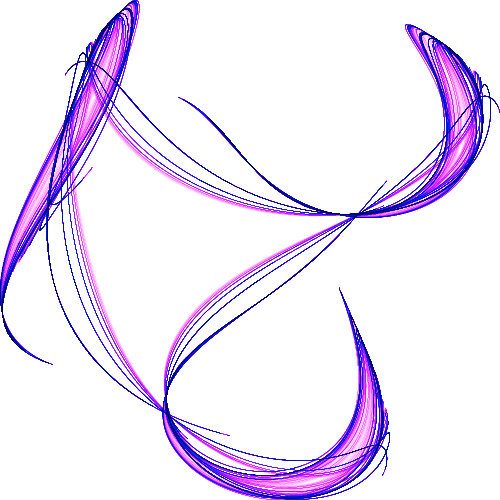

In [15]:
import numpy.random
#numpy.random.seed(21)
num = 1
im = 0

#Clifford
func = De_Jong#Svensson
n = 1e10 
while np.array(im).sum() < 1e13: #how intresting/colorful #1e12 lower limit
    rvals=np.c_[np.zeros((num,2)), numpy.random.random((num,4))*4-2]
    vals = list(rvals[0])

    im = dsplot(func, rvals[0])
    print(np.array(im).sum()) 

print(rvals)
  #[0.0, 0.0, -1.8188610188670555, 1.9846887872031358, -0.9332743385822719, -1.203888101820346]
  #[[ 0.          0.         -1.67181605 -1.75599106 -1.77558621 -1.79836293]]

plot(func, vals=[["bmw"]+list(rvals[i]) for i in range(len(rvals))], label=False)

200
287
412
592
850
1220
1752
2516
3614
5189
7451
10699
15363
22060
31676
45483
65309
93778
134655
193350
277630
398647
572414
821925
1180195
1694634
2433311
3493973
5016969
7203826
10343918
14852752
21326951
30623202
43971618
63138503
90660084
130178108
186921731
268399456
385392686
553382352
794597404
1140956216
1638290133
2352408027
3377804341
4850162911
6964311101
10000000000



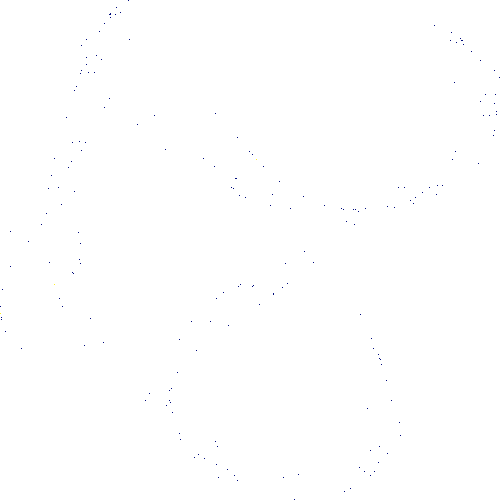
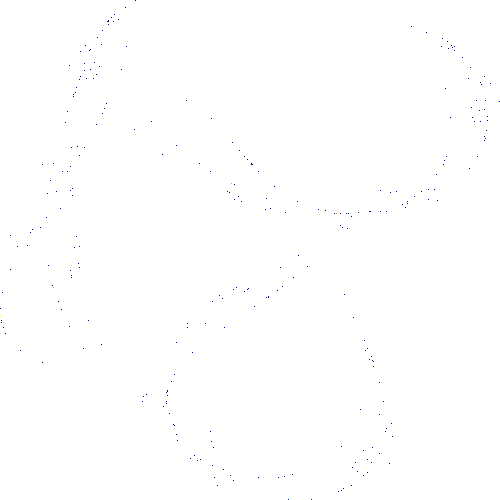
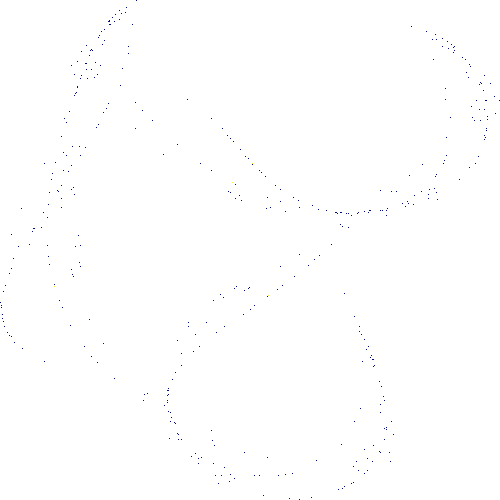
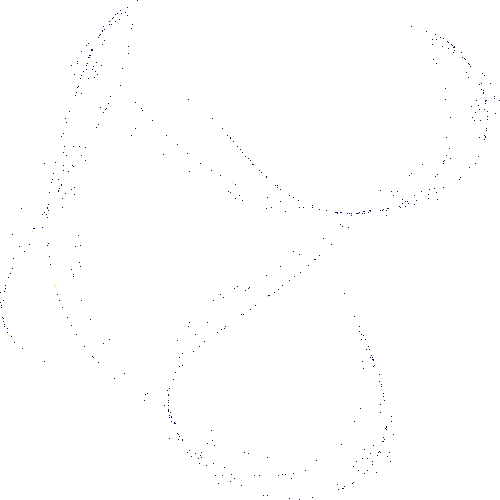
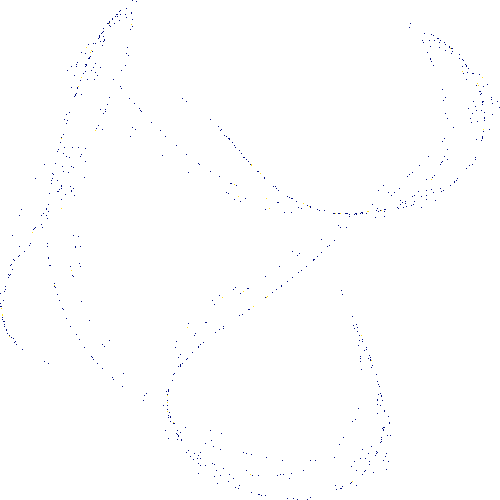
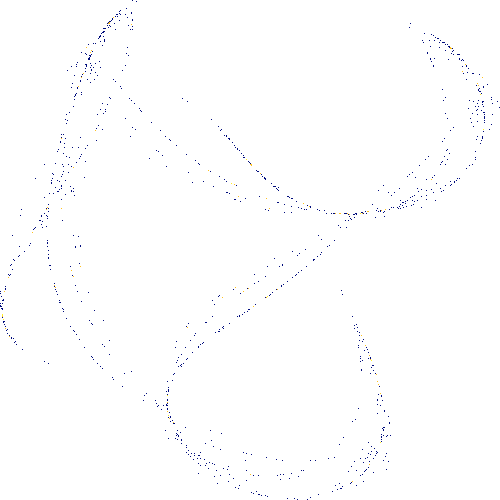
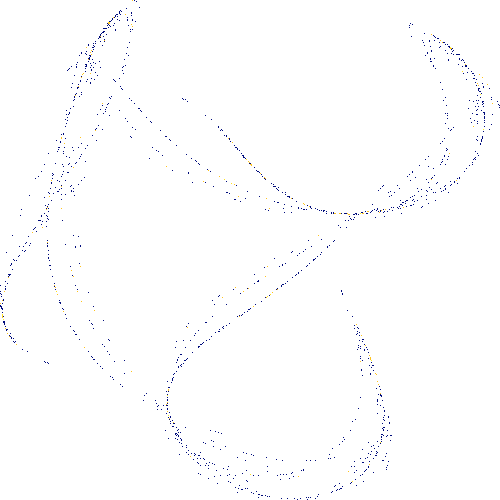
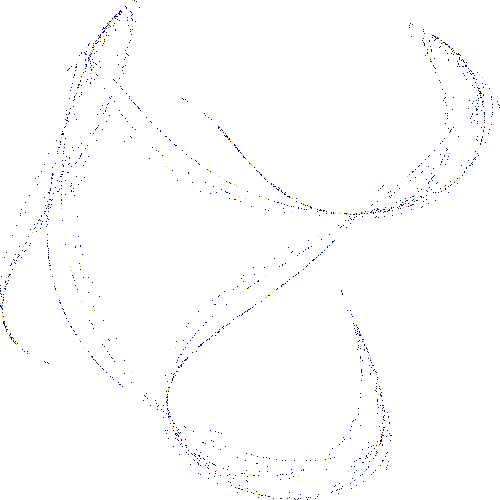
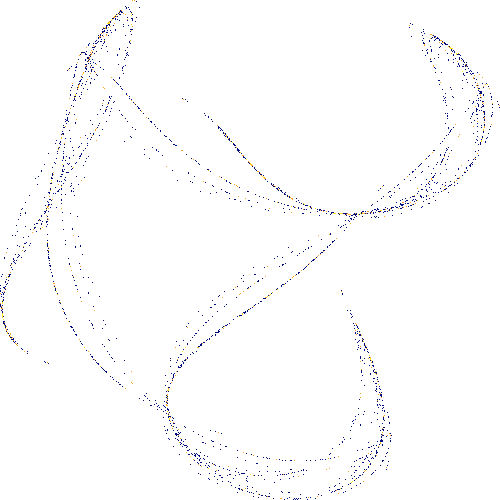
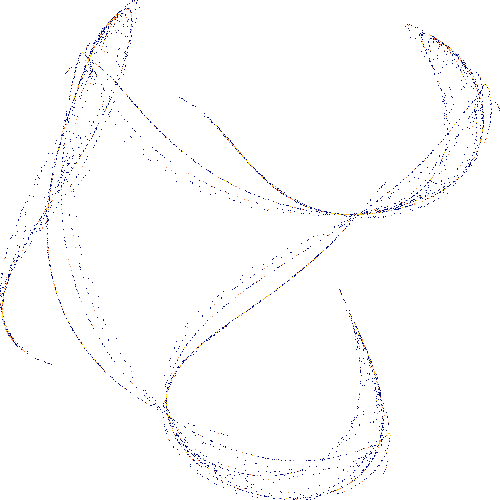
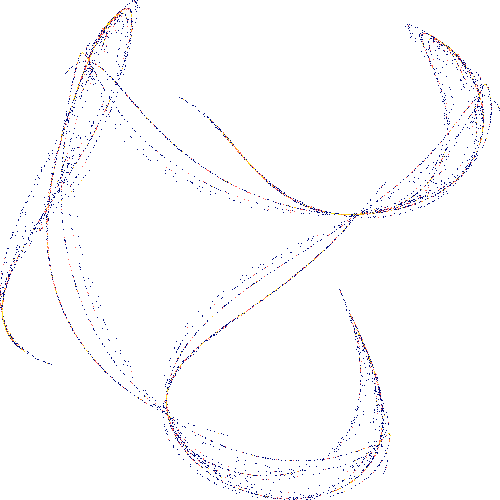
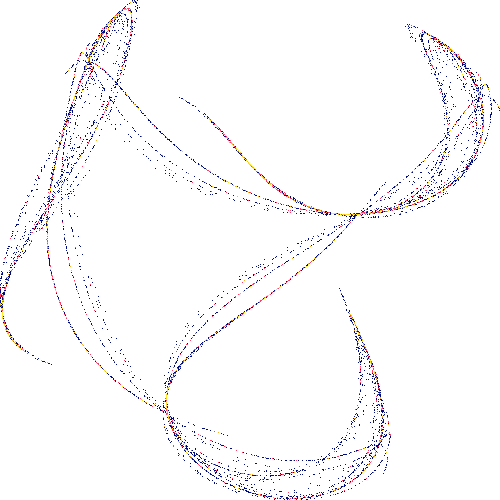
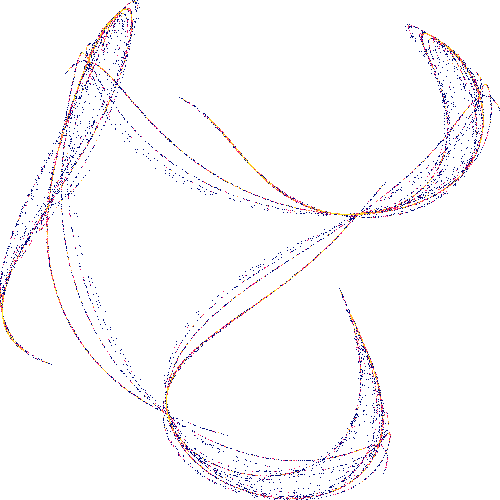
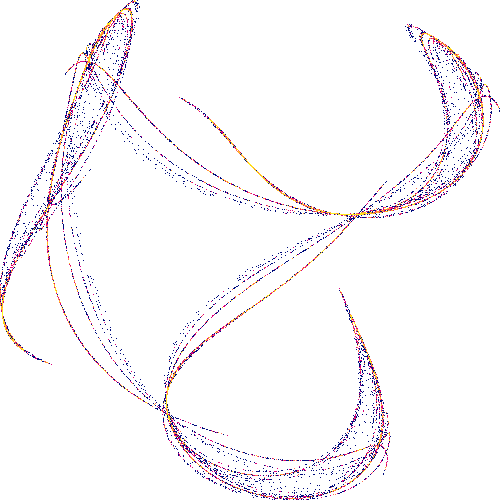
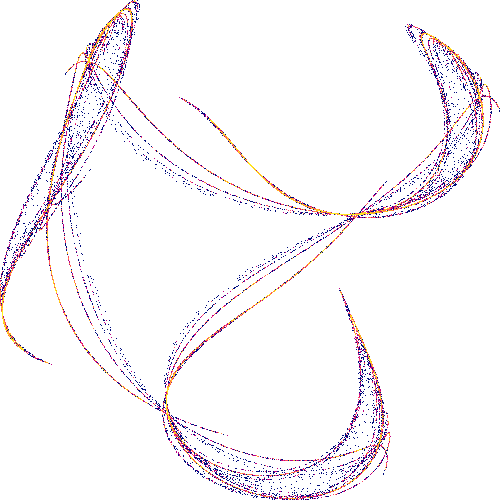
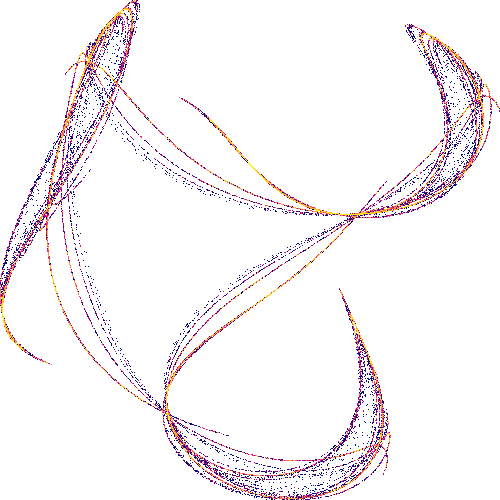
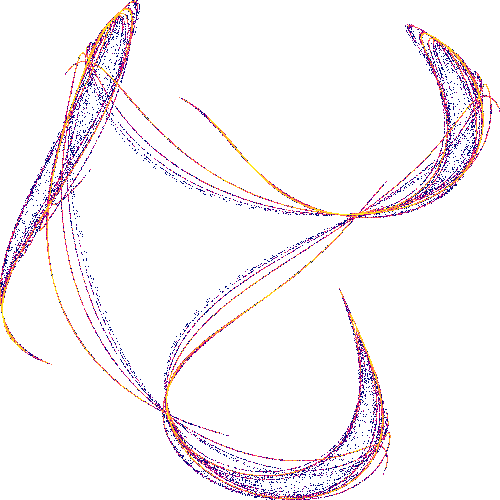
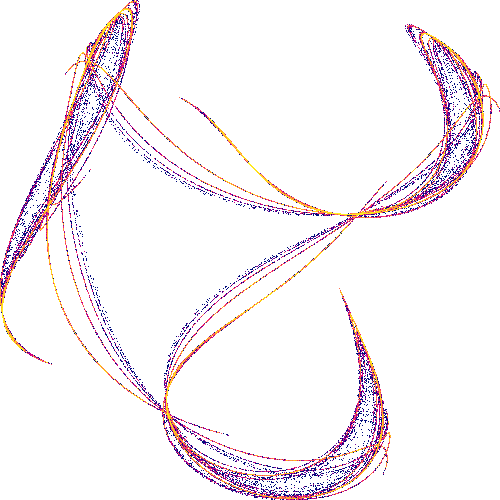
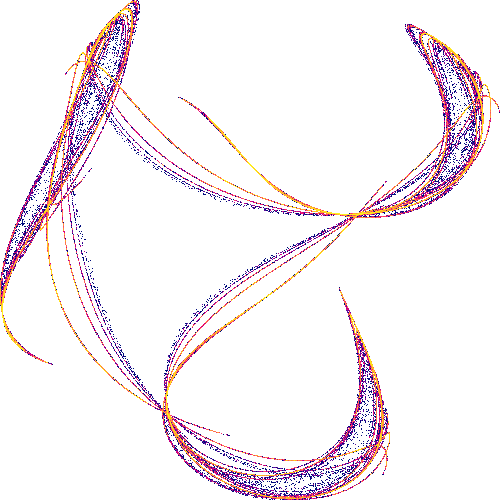
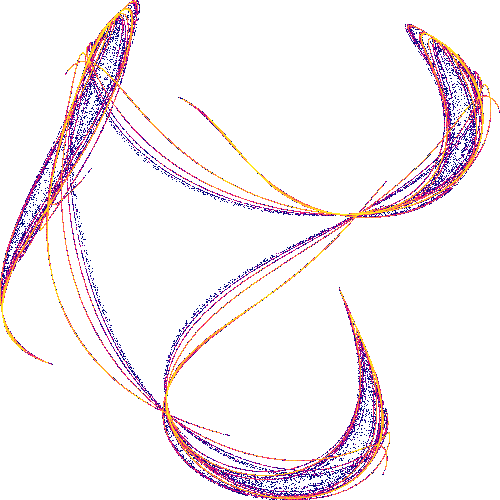
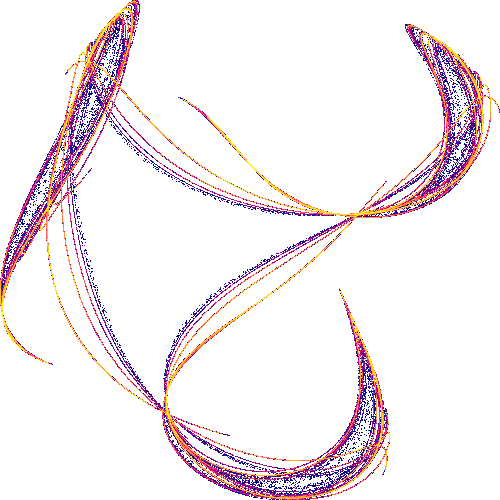
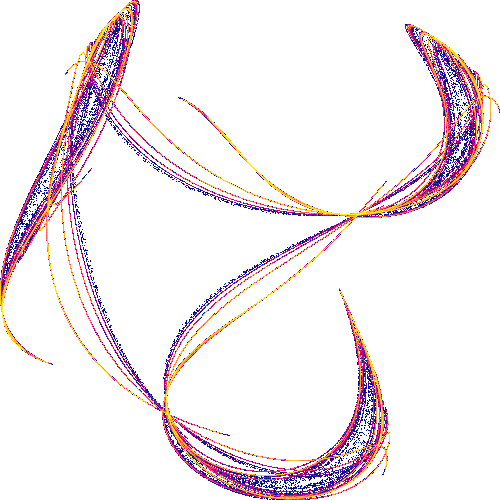
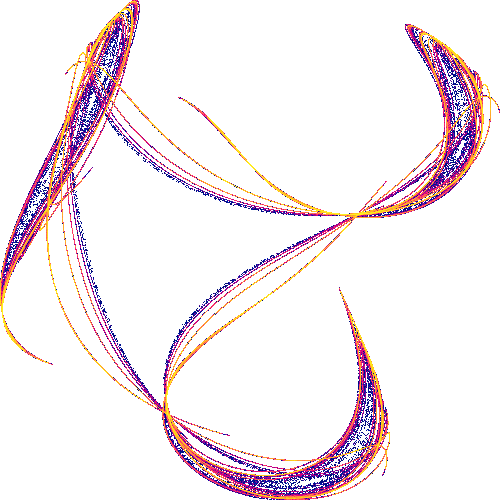
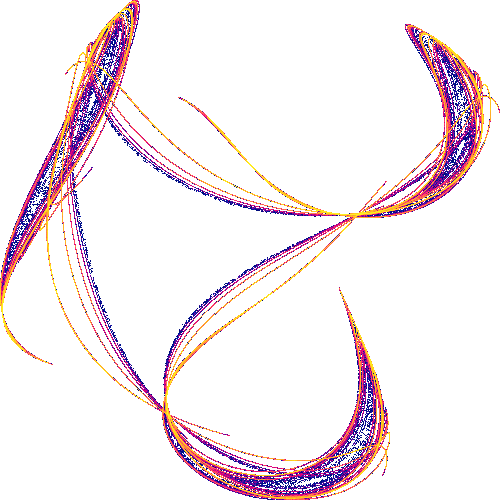
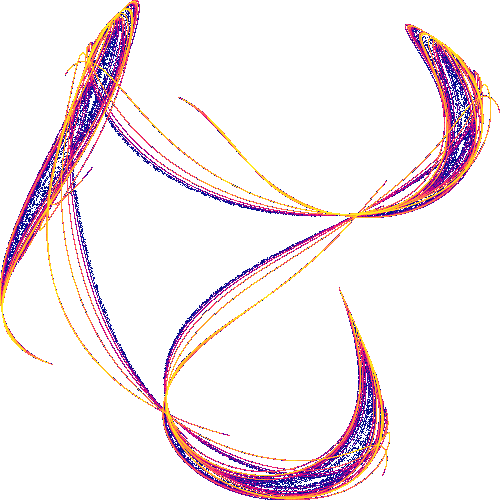
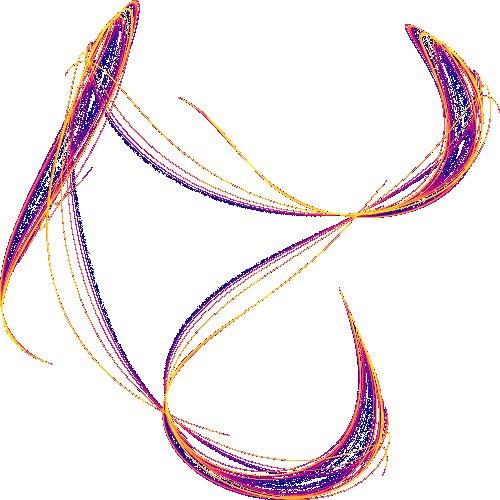
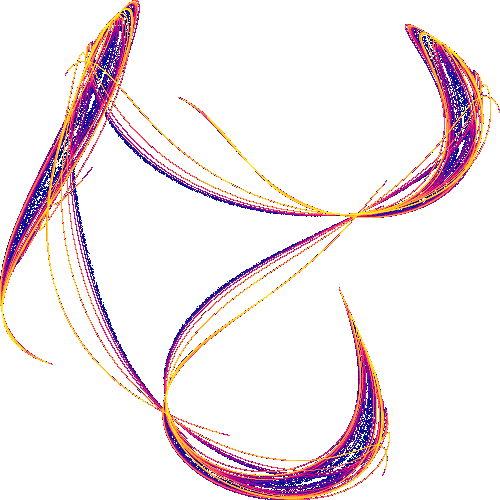
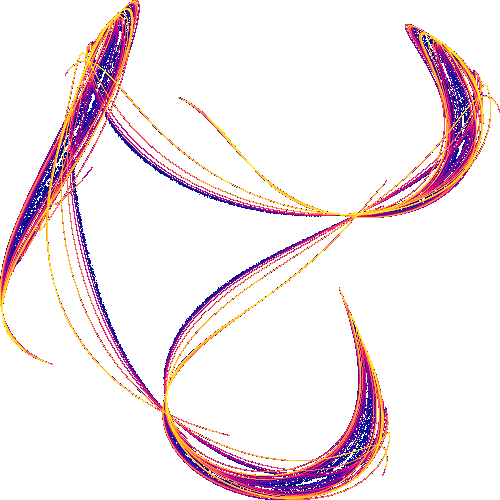
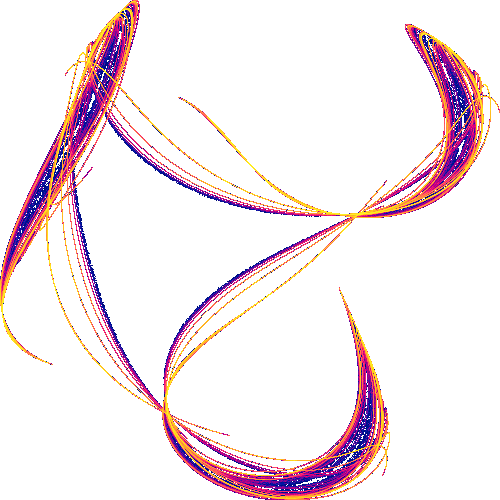
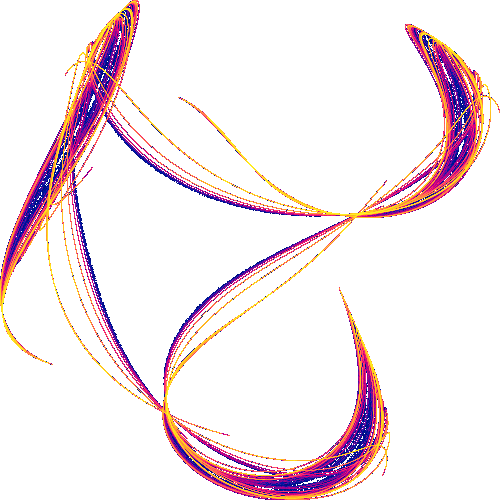
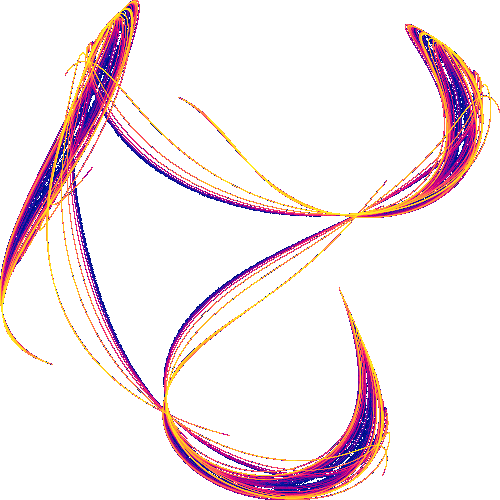
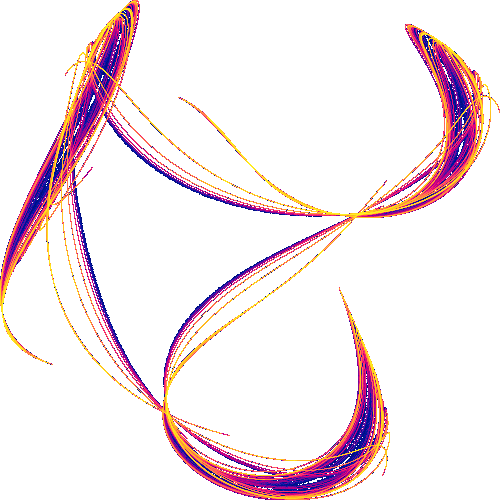
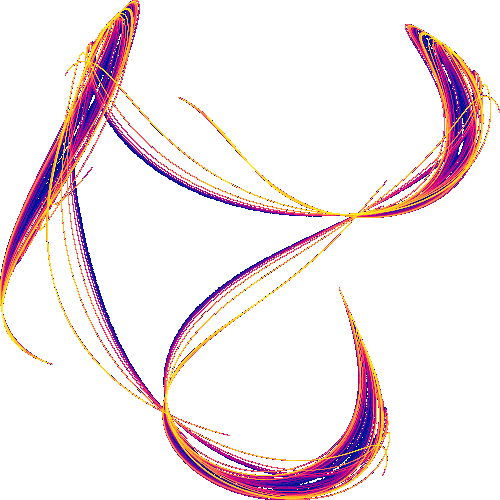
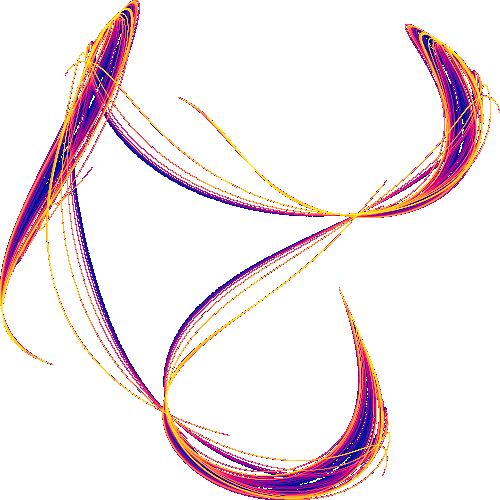
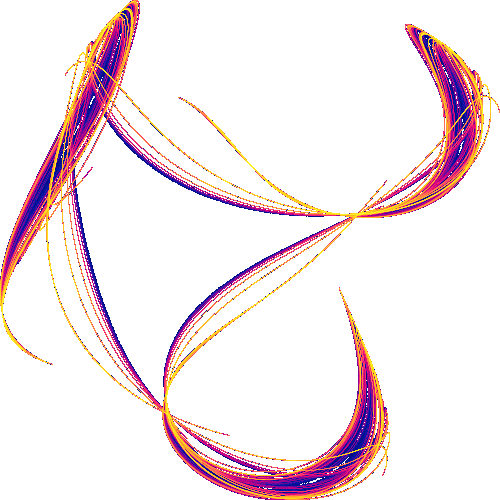
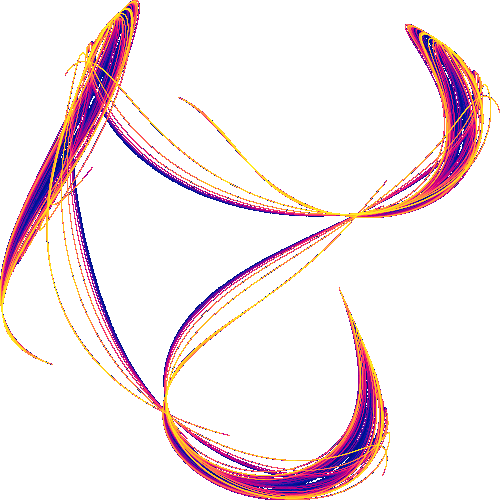
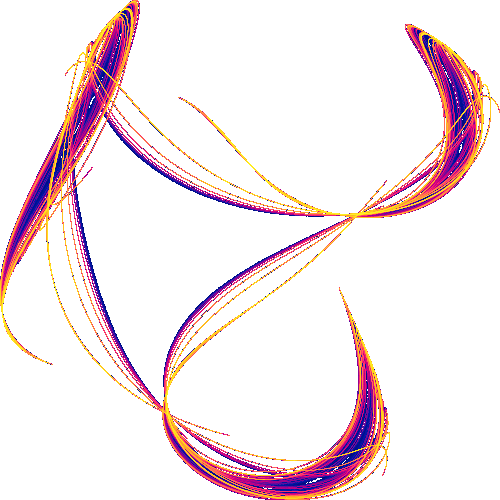
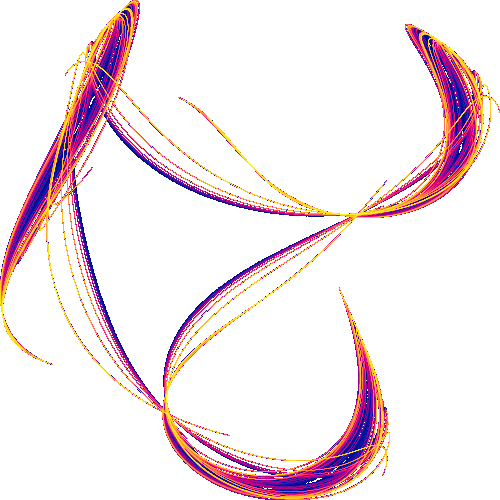
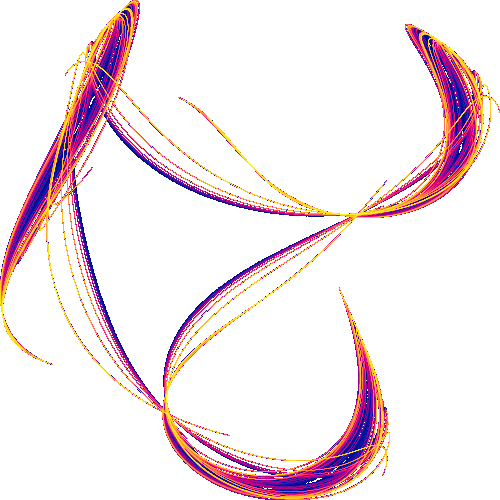
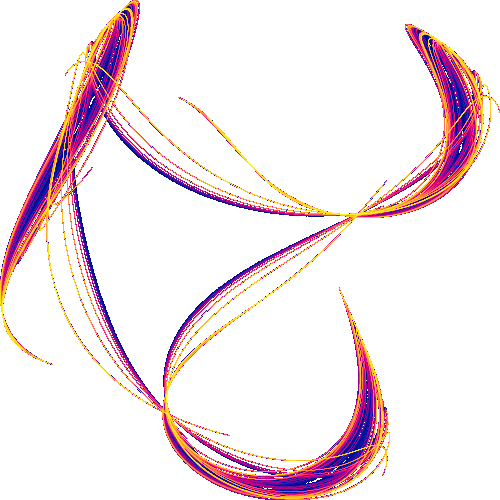
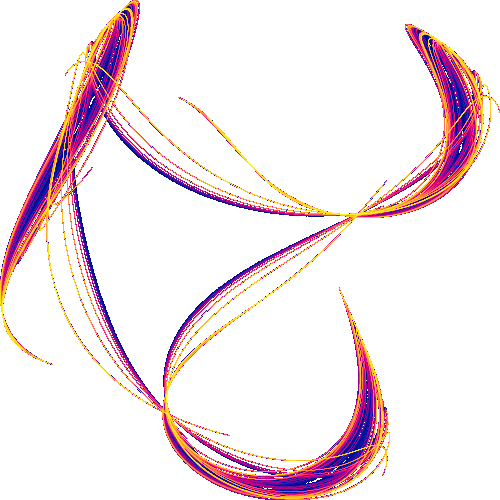
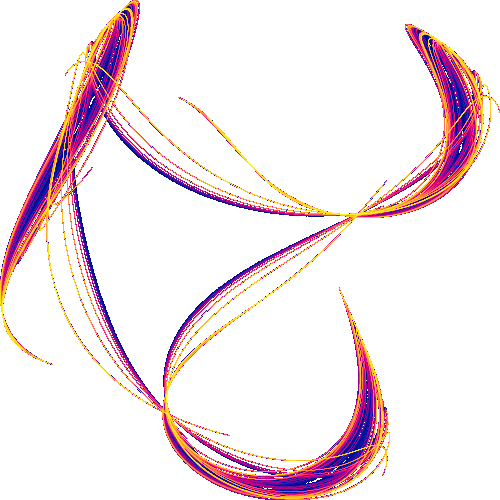
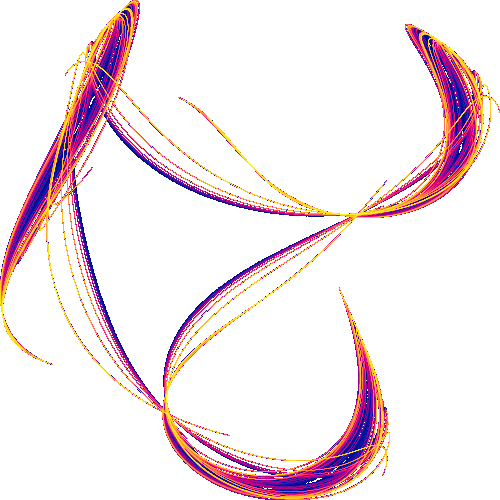
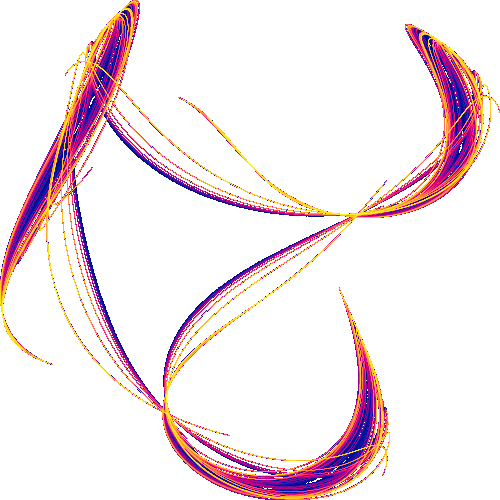
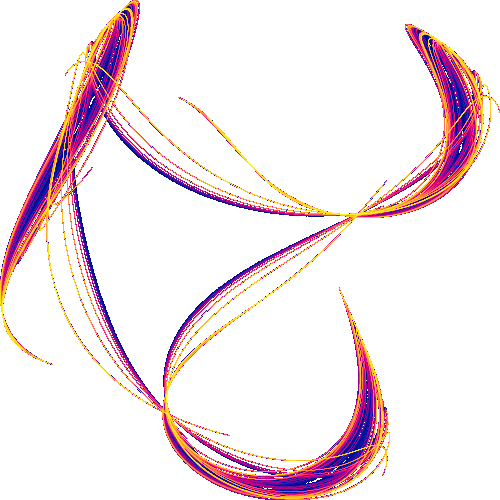
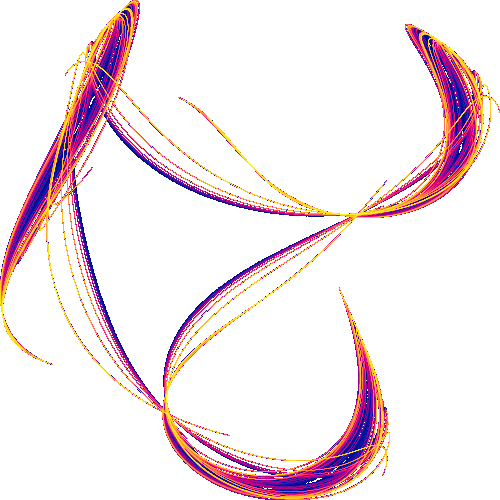
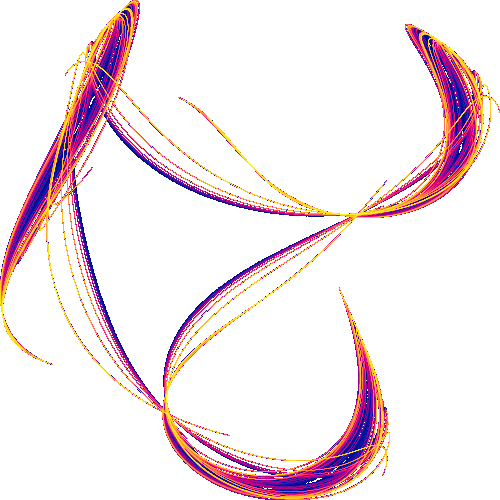
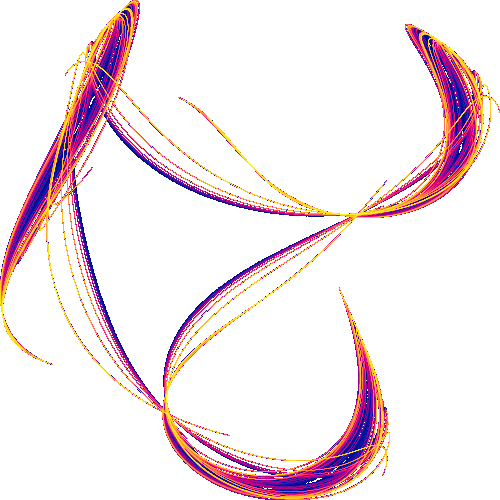
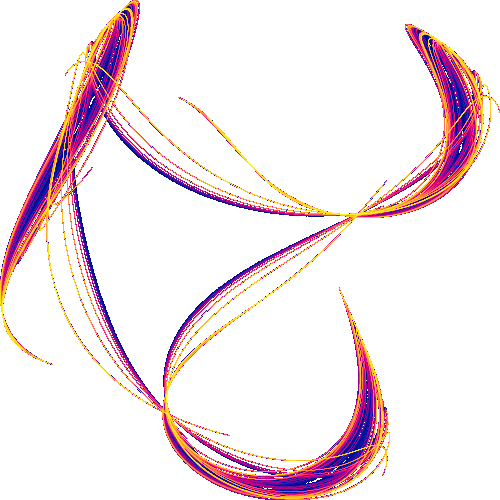
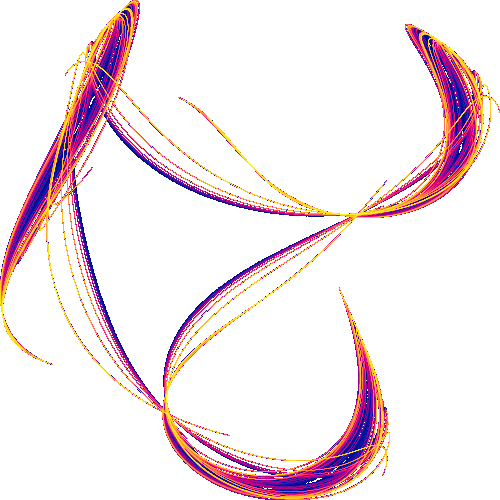

In [16]:
def myplot(fn, vals, n=n, cmap=viridis, label=True):
    """Return a Datashader image by collecting `n` trajectory points for the given attractor `fn`"""
    imgs = []
    lab = ("{}, "*(len(vals)-1)+" {}").format(*vals) if label else None
    df  = trajectory(fn, *vals, n)
    for i in np.geomspace(200, n, 50).astype(int):
        print(i)
        cvs = ds.Canvas(plot_width = 500, plot_height = 500)
        agg = cvs.points(df[:i], 'x', 'y')
        imgs.append(tf.shade(agg, cmap=palette["bmy"], name=lab))
    return imgs

import numpy.random
#numpy.random.seed(21)

#De_Jong [[0.         0.         1.75732393 1.84608731 1.28724688 1.64219255]]
#Clifford
func = De_Jong #Svensson

#rvals=[[0.0, 0.0, -1.8188610188670555, 1.9846887872031358, -0.9332743385822719, -1.203888101820346]]
#[[0.,0.,1.75732393, 1.84608731, 1.28724688, 1.64219255]]

n = 1e14
imgs_l = myplot(func, rvals[0])
#tf.Images(*[imgs, cmap=palette[v[0]][::-1], **kw) for v in vargs]).col(1)
tf.Images(*[i for i in imgs_l])

In [64]:


from PIL import Image  
import PIL  

#picture = Image.open(r'Downloads\3.jpg')  
#picture = imgs[1].save("dolls.jpg")

for i in range(len(imgs_l)):
    imgs_l[i].to_pil().save('images/{}.png'.format(str(i).zfill(3)))

import glob
from PIL import Image

# filepaths

fp_in = "images/*.png"
fp_out = "flip.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=250, loop=0)

In [66]:
imgs_1

NameError: name 'imgs_1' is not defined

In [56]:
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]


In [77]:
list_gen = []

for i in range(0, 50):
    i = str(i)
    if len(i) <= 1:
        i = str(f'images/00{i}.png')
        list_gen.append(i)
    else:
        i = str(f'images/0{i}.png')
        list_gen.append(i) 

In [78]:
list_gen

['images/000.png',
 'images/001.png',
 'images/002.png',
 'images/003.png',
 'images/004.png',
 'images/005.png',
 'images/006.png',
 'images/007.png',
 'images/008.png',
 'images/009.png',
 'images/010.png',
 'images/011.png',
 'images/012.png',
 'images/013.png',
 'images/014.png',
 'images/015.png',
 'images/016.png',
 'images/017.png',
 'images/018.png',
 'images/019.png',
 'images/020.png',
 'images/021.png',
 'images/022.png',
 'images/023.png',
 'images/024.png',
 'images/025.png',
 'images/026.png',
 'images/027.png',
 'images/028.png',
 'images/029.png',
 'images/030.png',
 'images/031.png',
 'images/032.png',
 'images/033.png',
 'images/034.png',
 'images/035.png',
 'images/036.png',
 'images/037.png',
 'images/038.png',
 'images/039.png',
 'images/040.png',
 'images/041.png',
 'images/042.png',
 'images/043.png',
 'images/044.png',
 'images/045.png',
 'images/046.png',
 'images/047.png',
 'images/048.png',
 'images/049.png']

In [79]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='images'
fps=10

image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(list_gen, fps=fps)

clip.write_videofile('my_video.mp4')

t:  10%|█         | 5/50 [00:00<00:00, 46.66it/s, now=None]

Moviepy - Building video my_video.mp4.
Moviepy - Writing video my_video.mp4



Moviepy - Done !
Moviepy - video ready my_video.mp4


In [54]:
import cv2
import os

image_folder = 'images'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
